<a href="https://colab.research.google.com/github/ShresthaPriya/AI-and-ML/blob/main/worksheet6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = '/content/drive/MyDrive/AI ML/Workshop5/FruitinAmazon/FruitinAmazon/train'

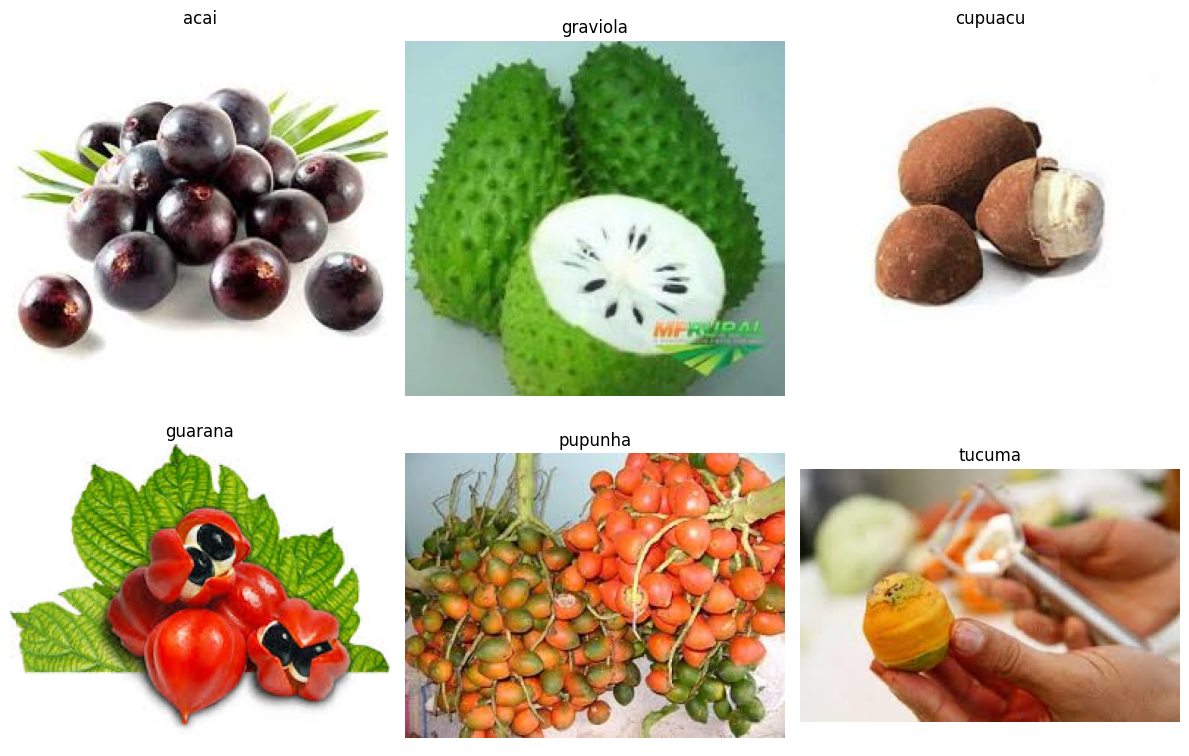

In [4]:
# list of class directories
class_dirs = os.listdir(train_dir)

# list to hold the images and labels
images = []
labels = []

for class_name in class_dirs:
  class_path = os.path.join(train_dir, class_name)
  image_files = os.listdir(class_path)

  # select a random image from each class
  random_image = random.choice(image_files)
  random_image_path = os.path.join(class_path, random_image)

  images.append(mpimg.imread(random_image_path))
  labels.append(class_name)

fig, axes = plt.subplots(nrows=2, ncols=len(class_dirs)//2, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(images)):
  ax = axes[i]
  ax.imshow(images[i])
  ax.set_title(labels[i])
  ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# list to store path to corrupted images
corrupted_images = []

# iterate through each class directory
for class_name in class_dirs:
  class_path = os.path.join(train_dir, class_name)
  # ensure it's a directory
  if os.path.isdir(class_path):
      # iterate through all image files in the class directory
      for image_name in os.listdir(class_path):
          image_path = os.path.join(class_path, image_name)

          #check if the file is an image (assuming common formats)
          if image_path.lower().endswith(('jpg', 'jpeg', 'png', 'gif')):
              try:
                  # try to open the image
                  with Image.open(image_path) as img:
                      img.verify()  # verify the image is not corrupted
                      width, height = img.size

                      # Print the height
              except (IOError, SyntaxError) as e:
                  # if an error occurs, it means the image is corrupted
                  corrupted_images.append(image_path)
                  os.remove(image_path)  # remove the corrupted image
                  print(f"Removed corrupted image: {image_path}")

# check the corrupted images
if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


In [6]:
# Data augmentation and normalization for training images
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,       # Normalize pixel values to [0, 1]
    validation_split=0.2  # Reserve 20% of data for validation
)

# Generator for training data with augmentations
training_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer-encoded labels
    subset='training',    # Use the training subset
    seed=1337
)

# Data generator for validation images (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generator for validation data (no augmentations)
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='validation',  # Use the validation subset
    seed=1337,
    shuffle=False         # Keep data in same order for consistency
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [7]:
# Set image dimensions and batch size
image_size = (128, 128)
batch_size = 64

# Build an improved CNN model
def create_cnn_model(input_shape=(128, 128, 3), num_classes=6):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    return model


In [8]:
# Create and compile model
model = create_cnn_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1725 - loss: 2.5881 - val_accuracy: 0.1667 - val_loss: 2.4602
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 797ms/step - accuracy: 0.4091 - loss: 1.7417 - val_accuracy: 0.1667 - val_loss: 1.7466
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - accuracy: 0.4867 - loss: 1.4193 - val_accuracy: 0.2222 - val_loss: 1.7778
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.3056 - loss: 2.4418 - val_accuracy: 0.1667 - val_loss: 1.9135
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5139 - loss: 1.3709 - val_accuracy: 0.2222 - val_loss: 1.8952


In [11]:
test_dir = "/content/drive/MyDrive/AI ML/Workshop5/FruitinAmazon/FruitinAmazon/test"  # Replace with your test data path
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.2333 - loss: 1.7358
Test accuracy: 0.2333


In [13]:
test_gen_1 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    seed=1337
)

Found 30 images belonging to 6 classes.


In [14]:
test_loss, test_acc = model.evaluate(test_gen_1)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.2333 - loss: 1.7358
Test accuracy: 0.2333


# Task 2

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

In [16]:
class_name = sorted(os.listdir(train_dir))

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model except from block conv 5
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [17]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [19]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_name), activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 7,610,886 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2
)

# Training data generator
training_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated image size
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

# Create ImageDataGenerator for validation (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Validation data generator
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [26]:
model.fit(
    training_data,
    validation_data=validation_data,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ])

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 17s/step - accuracy: 0.1539 - loss: 1.9694 - val_accuracy: 0.1667 - val_loss: 1.7833
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 74s/step - accuracy: 0.1944 - loss: 1.7923 - val_accuracy: 0.3333 - val_loss: 1.7768
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 17s/step - accuracy: 0.2789 - loss: 1.7762 - val_accuracy: 0.1667 - val_loss: 2.7979
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 17s/step - accuracy: 0.1921 - loss: 2.5309 - val_accuracy: 0.1667 - val_loss: 2.2531
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 27s/step - accuracy: 0.1539 - loss: 2.1932 - val_accuracy: 0.1667 - val_loss: 1.7807


Shape-224

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training with augmentation and normalization
train_datagen_2 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2  # Split 20% for validation
)

# Training data generator with image size 224x224
train_generator_2 = train_datagen_2.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated shape
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

# ImageDataGenerator for validation (only rescaling, no augmentation)
val_datagen_2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Validation data generator with image size 224x224
validation_generator_2 = val_datagen_2.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Keep data order consistent for validation
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [30]:
# Load pre-trained VGG16 model without the top classifier layer
base_model_224 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers to prevent them from training
for layer in base_model_224.layers:
    layer.trainable = False

# Add custom classification head
x224 = base_model_224.output
x224 = GlobalAveragePooling2D()(x224)
x224 = Dense(1024, activation='relu')(x224)
predictions224 = Dense(len(class_name), activation='softmax')(x224)

# Build the complete model
model224 = Model(inputs=base_model_224.input, outputs=predictions224)

# Compile the model
model224.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
model224.summary()

# Train the model
history224 = model224.fit(
    train_generator_2,
    validation_data=validation_generator_2,
    epochs=15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

# Evaluate on validation set
val_loss224, val_acc224 = model224.evaluate(validation_generator_2)
print(f"Validation Accuracy: {val_acc224:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 52s/step - accuracy: 0.1852 - loss: 2.0268 - val_accuracy: 0.2222 - val_loss: 1.9249
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 50s/step - accuracy: 0.2963 - loss: 1.8513 - val_accuracy: 0.1667 - val_loss: 1.8948
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 50s/step - accuracy: 0.3148 - loss: 1.7903 - val_accuracy: 0.3333 - val_loss: 1.6197
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 94s 27s/step - accuracy: 0.4051 - loss: 1.5626 - val_accuracy: 0.3333 - val_loss: 1.5754
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 16s/step - accuracy: 0.5475 - loss: 1.4769 - val_accuracy: 0.5000 - val_loss: 1.5922
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 50s/step - accuracy: 0.4583 - loss: 1.4279 - val_accuracy: 0.4444 - val_loss: 1.5625
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 66s 25s/step - accuracy: 0.5000 - loss: 1.3791 - val_accuracy: 0.5000 - val_loss: 1.4330
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 26s/step - accuracy: 0.5972 - loss: 1.2407 - val_accuracy: 0.5556 - val_loss: 1.3063


In [31]:
import numpy as np
from sklearn.metrics import classification_report

# Ensure the validation generator does NOT shuffle (important for label order)
validation_generator_2.shuffle = False

# Get true class labels from the generator
true_labels = validation_generator_2.classes

# Get class label names in the correct order
class_labels = list(validation_generator_2.class_indices.keys())

# Predict probabilities for each class
pred_probs = model224.predict(validation_generator_2)

# Convert predicted probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)

# Generate and print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.50      1.00      0.67         3
    graviola       1.00      0.67      0.80         3
     guarana       0.33      0.67      0.44         3
     pupunha       0.50      0.33      0.40         3
      tucuma       1.00      0.33      0.50         3

    accuracy                           0.56        18
   macro avg       0.72      0.56      0.55        18
weighted avg       0.72      0.56      0.55        18



In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator_2 = test_datagen.flow_from_directory(
    test_dir,                  # Path to test dataset
    target_size=(224, 224),    # Resize images to 224x224 to match model input
    batch_size=64,
    class_mode='sparse',       # Use 'sparse' for integer labels
    seed=1337,
    shuffle=False              # Keep order fixed for evaluation
)


Found 30 images belonging to 6 classes.


In [33]:
test_loss, test_acc = model224.evaluate(test_generator_2)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5667 - loss: 1.2706
Test Accuracy: 0.5667


In [34]:
test_predictions = model224.predict(test_generator_2)
predicted_classes = np.argmax(test_predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


In [35]:
import numpy as np
from sklearn.metrics import classification_report

# Ensure the test generator does NOT shuffle
test_generator_2.shuffle = False

# Get true labels from the test generator
true_labels = test_generator_2.classes

# Get class labels in correct order
class_labels = list(test_generator_2.class_indices.keys())

# Make predictions on the test set
pred_probs = model224.predict(test_generator_2)

# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Generate and print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Classification Report
              precision    recall  f1-score   support

        acai       0.33      0.20      0.25         5
     cupuacu       0.60      0.60      0.60         5
    graviola       0.83      1.00      0.91         5
     guarana       0.40      0.80      0.53         5
     pupunha       0.67      0.40      0.50         5
      tucuma       0.67      0.40      0.50         5

    accuracy                           0.57        30
   macro avg       0.58      0.57      0.55        30
weighted avg       0.58      0.57      0.55        30

